## <h1 align="center">Actividad: Agrupar datos textuales con el Modelo de Tópicos y el algoritmo Latent Dirichlet Allocation (LDA)</h3>

<div style="border: 2px solid #1c75c8; background-color: #c5ddf6;">
<h2> Preámbulo</h2>
<p> Esta actividad se inspira de ejercicios disponibles en los recursos siguientes:<p>
<ul>
    <li>Biblioteca <a href="http://scikit-learn.org/stable/install.html/">SciKit-learn</a> de Python</li>
    <li>Código disponible en  <a href="https://github.com/lda-project/lda/">lda-project</a></li>
    <li>Material elaborado por el Prof. Matthieu Vernier</li>
</ul>
<p> La actividad requiere el uso de Python 3.x y <a href="http://jupyter.org/install">Jupyter Notebook</a>. El código entregado fue probado con Python 3.7.3. Para saber cuál versión de Python usted está utilizando, ejecutar la celda siguiente (está información es importante cuando se necesitará instalar nuevos paquetes.)
</p>
</div>

In [1]:
import sys
print(sys.version)

3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]



<div style="border: 2px solid #D24747; background-color:#F8B4B4">
<h2>Objetivos de la actividad</h2>
<p>El <b>objetivo general</b> de esta actividad consiste en  explorar la estructura oculta de un conjunto de datos textuales.</p>
<p> Comenzaremos por utilizar un  algoritmo de clustering tradicional como Kmeans para explorar datos textuales, considerando la medida tf-idf por cada término presente en cada texto, para caracterizar los textos y construir distancias entre ellos.</p>
<p>En una segunda fase utilizaremos el <a href="https://drive.google.com/open?id=1rSQPJvRVj0V_IChzspQMRPNwlDTkHYHp"> Modelo Probabilista De Tópicos </a> para descubrir tópicos en los textos. Para ello se utilizará el algoritmo de asignación de tópicos latentes conocido como <a href= "https://drive.google.com/open?id=1BobImO3192hifZPLXowd14gryVAUzBPW">Latent Dirichlet Allocation (LDA)</a>. El enfoque es probabilista, por lo que el resultado del algoritmo es descubrir tópicos en los textos (el número de tópicos es definido por el analista) y asignar una distribución de probabilidad de tópicos en cada texto.</p>  Dependiendo del tamaño de los textos, es también posible agruparlos de acuerdo al tópico con mayor representación en cada uno, lo que permitirá comparar esta metodología con los algoritmos de clustering clásicos.</p> </div>
    
  

<div style="border: 2px solid #D24747; background-color:#F8B4B4">
<p>Utilizaremos las 100 primeras noticias de un conjunto de datos provenientes del periódico El Dinamo.</p>   
<p>El primer paso es la lectura de datos: </p></div>

In [3]:
import pandas as pd
#from pandasql import sqldf #para utilizar una síntaxis SQL para consultar nuestros datos

dataset="contaminaciónacústica_chile_2018-01-01_2021-12-31.csv"
df = pd.read_csv(dataset)
df[:5]

,Unnamed: 0,id_news,country,media_outlet,url,title,text,date,search
0,0,17785718.0,chile,emol,https://www.emol.com/noticias/Autos/2021/02/24...,Estudio advierte que la contaminación acústica...,La prestigiosa revista estadounidense The Atl...,2021-02-25,contaminación acústica
1,1,22416427.0,chile,laestrelladechiloe,https://www.laestrellachiloe.cl/impresa/2021/0...,La contaminación acústica,"La contaminación acústica, según la Organizaci...",2021-06-15,contaminación acústica
2,2,261700.0,chile,biobiochile,https://www.biobiochile.cl/noticias/nacional/r...,Justicia ordena al municipio de Concepción fis...,La Municipalidad de Concepción deberá fiscaliz...,2020-07-02,contaminación acústica
3,3,22330373.0,chile,elllanquihue,https://www.ellanquihue.cl/impresa/2021/07/07/...,Contaminación acústica,"La contaminación acústica, según la Organizaci...",2021-07-07,contaminación acústica
4,4,13871464.0,chile,emol,https://www.emol.com/noticias/Nacional/2018/11...,Los siete puntos estratégicos de Santiago que ...,SANTIAGO.- El Ministerio del Medio Ambiente ...,2018-11-21,contaminación acústica


In [6]:
!pip install spacy
!python -m spacy download es_core_news_md

[+] Download and installation successful
You can now load the package via spacy.load('es_core_news_md')


In [4]:
noticias = df[:100].text
len(noticias)
noticias[:10]

0    La prestigiosa revista estadounidense  The Atl...
1    La contaminación acústica, según la Organizaci...
2    La Municipalidad de Concepción deberá fiscaliz...
3    La contaminación acústica, según la Organizaci...
4    SANTIAGO.- El  Ministerio del Medio Ambiente  ...
5    La ministra del Medio Ambiente, Carolina Schmi...
6    La contaminación acústica es el enemigo invisi...
7    BOSTON.- El ruido en las ciudades es algo que ...
8    La contaminación acústica influye en la calida...
9     Haileen Piedra Coordinadora de Marketing Mide...
Name: text, dtype: object

In [8]:
import spacy
nlp = spacy.load("es_core_news_md")

def spacy_tokenizer(texto):
    # crea lista de tokens a partir de un texto
    mytokens = []
    doc = nlp(texto.lower().strip())
    for token in doc:
        if not token.is_stop and not token.is_punct and not token.is_space and not token.is_digit and not token.like_num:
            mytokens.append(token.lemma_)
    return mytokens




In [9]:
#Utilizando Kmeans y tf-idf para realizar un primer agrupamiento de las noticias
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

myStopWords=['a','e','o','u','y',' ','  ','   ','    ']
vectorizer = TfidfVectorizer(tokenizer=spacy_tokenizer, stop_words=myStopWords, ngram_range=(1,1))

X=vectorizer.fit_transform(noticias) 
X_term = vectorizer.get_feature_names()



In [10]:
import numpy as np
print(X_term[:20])
print(X.shape)
print(noticias[:1])
print(X[:1])
sumTextos = np.sum(X, axis=1)
print(len(sumTextos))
print(sumTextos[:10])

['$', '+', '-al', '-aunque', '-como', '-de', '-denunciado', '-en', '-es', '-frontera', '-integrado', '-junto', '-mantener', '-moz-background-size', '-no', '-o-background-size', '-plantear', '-por', '-producida', '-puntualizó-']
(88, 6269)
0    La prestigiosa revista estadounidense  The Atl...
Name: text, dtype: object
  (0, 5616)	0.06420881539850011
  (0, 5325)	0.06420881539850011
  (0, 4719)	0.0255084160617998
  (0, 2272)	0.0413832284275956
  (0, 5058)	0.05877987306330863
  (0, 2803)	0.03210239020548982
  (0, 1882)	0.06420881539850011
  (0, 1236)	0.054927977176394326
  (0, 4000)	0.06420881539850011
  (0, 5687)	0.06420881539850011
  (0, 1859)	0.02986563302377793
  (0, 4401)	0.03914647124588371
  (0, 2251)	0.06420881539850011
  (0, 2021)	0.06420881539850011
  (0, 5661)	0.03478925428390558
  (0, 4062)	0.0340653255891039
  (0, 2349)	0.037230434051296744
  (0, 3406)	0.05194021460859401
  (0, 5501)	0.054927977176394326
  (0, 6151)	0.06420881539850011
  (0, 2139)	0.054927977176394326
  (0, 3

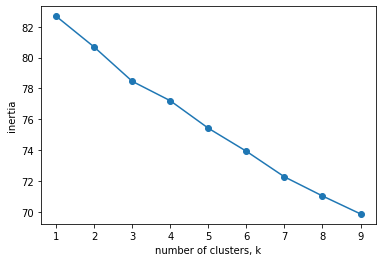

In [12]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt


num_k = range(1, 10)
inertias = []

for k in num_k:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k, n_init=10)

    # Fit model to samples
    model.fit(X)

    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)


# Plot ks vs inertias
plt.plot(num_k, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(num_k)
plt.show()

<div style="border: 2px solid #1c75c8; background-color: #c5ddf6;">
<p>Pregunta Nº1: Explore las clases TfidfVectorizer, CountVectorizer. ¿Qué rol cumplen? ¿Qué tratamiento premilinar de textos se ha hecho en este caso? ¿Qué rol cumple n_gram?</p>
<p>Pregunta Nº2: A partir del gráfico, justifique el número de clusters para estos datos.</p>
</div>

In [13]:
from matplotlib.pylab import hist, show
true_k = 3
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=10)
model.fit(X)
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

for i in range(true_k):
    cluster_words = np.array(terms)[order_centroids[i, :15]]
    print('Cluster {}: {}'.format(i, '-'.join(cluster_words)))



                                    

Top terms per cluster:
Cluster 0: ballena-especie-delfín-agua-marino-zona-cetáceo-urbano-población-hong-empresa-mamífero-proyecto-ciudad-kong
Cluster 1: ruido-decibel-nivel-ciudad-salud-ambiente-contaminación-db-persona-ambiental-fuente-acústico-oms-sonido-noche
Cluster 2: vecino-parque-proyecto-eléctrico-bus-camión-empresa-vara-sector-transporte-obra-=-santiago-sur-senda


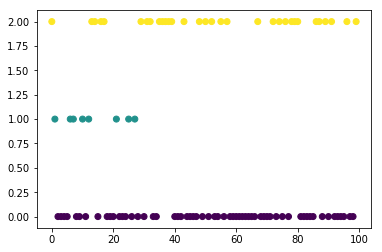

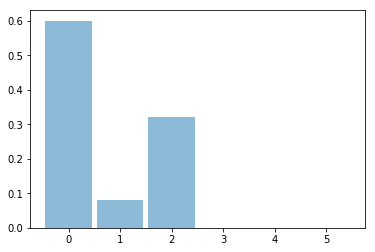

In [9]:
#Generando algunos gráficos de los resultados
labels = model.predict(X)
plt.scatter(range(100),labels,c=labels)
show()
hist(labels,bins=np.arange(-0.5,5.6,1),alpha=0.5,rwidth=0.9,density=True)
show()

<div style="border: 2px solid #1c75c8; background-color: #c5ddf6;">
<p>Pregunta Nº3:Explore diversos valores en los parámetros de n_init y max_iter. ¿tienen influencia en los resultados? ¿Por qué? Describa e interprete los resultados.</p></div>

<div style="border: 2px solid #1c75c8; background-color: #F8B4B4">
<p>En lo que sigue se construye un modelo probabilista de tópicos, considerando de 1 a 9 tópicos (para comparar con Kmeans
 y el algoritmo LDA estimado con el <a href="https://drive.google.com/open?id=1AoCcmg91Y1yRwM_Ox4Nvf6PGSQ9TybpE">, método de Bayes Variacional</a>, disponible como desarrollo en <a href="http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html">sklearn-lda.</a></p> 
Previo a ello se utiliza la clase CountVectorizer y su función fit_transform que permite construir una matriz tf (DTM, Document-Term Matrix) que contiene la frecuencia de aparición de cada término del vocabulario en cada texto analizado. En la definición de la clase se especifica que:
<ol>
    <li>los términos que  aparecen sólo una vez en algún texto no serán considerados en el vocabulario (min_df=2)</li>
    <li> los términos que  aparecen en mas del 95% de los textos no serán considerados en el vocabulario (max_df=0.95)</li>
    <li> se considera adicionalmente un conjunto de stop words construido ad-hoc, posible de refinar</li>
</ol></div>

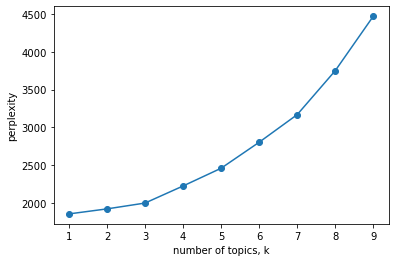

In [14]:
#Aplicando Modelos Probabilistas de Tópicos y LDA
from sklearn.decomposition import LatentDirichletAllocation

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()
    
myStopWords=['a','e','o','u','y',' ','  ','   ','   ','    ']
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                stop_words=myStopWords,tokenizer=spacy_tokenizer, ngram_range=(1,1))
tf = tf_vectorizer.fit_transform(noticias)
diccionario= tf_vectorizer.get_feature_names()


perp = []
for k in num_k:
    #Estimación de LDA con Bayes Variacional
    lda = LatentDirichletAllocation(n_components=k, max_iter=10,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

    lda.fit(tf)
    #Cálculo de índice de ajuste de los datos
    perp.append(lda.perplexity(tf))

plt.plot(num_k, perp, '-o')
plt.xlabel('number of topics, k')
plt.ylabel('perplexity')
plt.xticks(num_k)
plt.show()

#print("\nTopics in LDA model:")
#print_top_words(lda, diccionario, 15)


<div style="border: 2px solid #1c75c8; background-color: #c5ddf6;">
<p>Pregunta Nº4: Indage sobre la medida perplexity, ¿Cómo se interpreta el valor obtenido?
</p></div>

[[9.96354848e-01 1.77183970e-03 1.87331215e-03]
 [9.96173814e-01 1.89389257e-03 1.93229369e-03]
 [9.91022517e-01 4.18837847e-03 4.78910484e-03]
 [9.96573295e-01 1.69848015e-03 1.72822508e-03]
 [9.96740543e-01 1.54385221e-03 1.71560519e-03]
 [8.80267746e-01 2.24649364e-03 1.17485761e-01]
 [8.02284350e-01 7.41388550e-03 1.90301765e-01]
 [9.94514309e-01 2.62666990e-03 2.85902077e-03]
 [8.85510984e-01 3.31031589e-02 8.13858568e-02]
 [9.96398788e-01 1.77953411e-03 1.82167791e-03]
 [9.96398788e-01 1.77953411e-03 1.82167791e-03]
 [3.16662833e-01 1.31371018e-03 6.82023456e-01]
 [5.35060837e-01 6.11178237e-03 4.58827381e-01]
 [3.61204519e-03 3.42269925e-03 9.92965256e-01]
 [9.96637738e-01 1.66979115e-03 1.69247038e-03]
 [3.61859585e-03 3.62260126e-03 9.92758803e-01]
 [4.48230642e-03 9.91028186e-01 4.48950807e-03]
 [2.71269319e-01 1.10282226e-02 7.17702458e-01]
 [9.92315700e-01 3.78129250e-03 3.90300767e-03]
 [9.92534328e-01 3.53145408e-03 3.93421800e-03]
 [2.86072801e-03 2.68794590e-03 9.944513

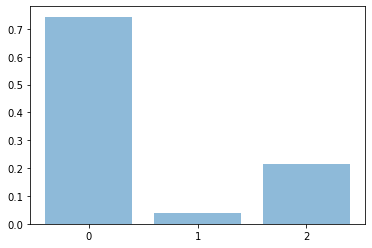

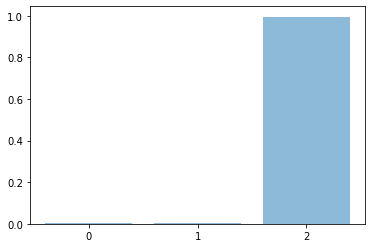

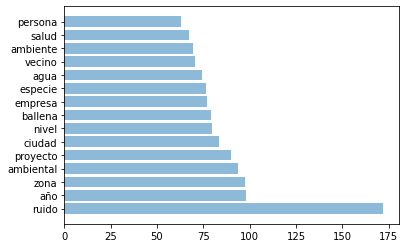

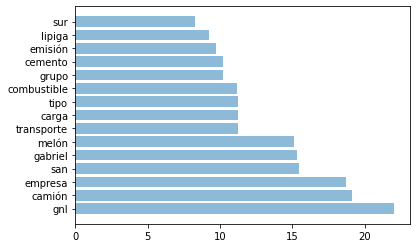

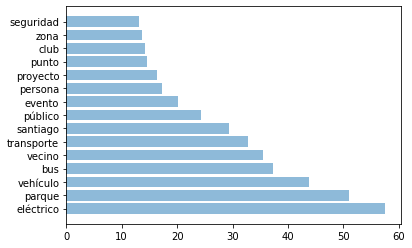

In [20]:
#Generando algunos gráficos de los resultados
from matplotlib.pylab import hist, show
import seaborn as sns

lda = LatentDirichletAllocation(n_components=true_k, max_iter=100,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
y=lda.fit_transform(tf)

print(y)
#distribución de tópicos en todos los documentos
dist = sum(y)/len(noticias)
print(dist)

w=np.arange(0,true_k)
print(w)
plt.bar(w,height=dist,alpha=0.5,tick_label=w)
show()
#distribución de tópicos en el documento 51
plt.bar(w,height=y[50],alpha=0.5,tick_label=w)
show()


#frecuencia de palabras por tópico
n_top_words=15
numo =np.arange(0,n_top_words)
for idx,topic in enumerate(lda.components_):
    d =[]
    s = []
    for i in topic.argsort()[:-n_top_words - 1:-1]:
        s.append(diccionario[i])
        d.append(topic[i])
    
    plt.barh(numo,width=d,alpha=0.5,tick_label=s)
    show()


<div style="border: 2px solid #1c75c8; background-color: #c5ddf6;">
<p>Pregunta Nº5: Interprete estos gráficos. 
</p></div>

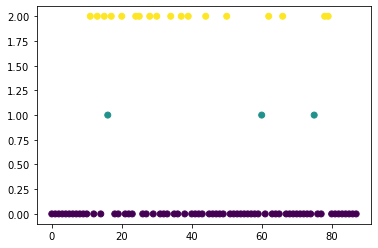

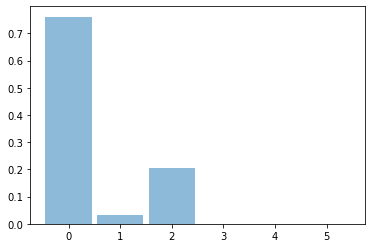

In [22]:
#calculando cluster en base al tópico mas frecuente
z=[]
for i in range(len(noticias)):
    z.append(np.argmax(y[i]))
plt.scatter(range(88),z,c=z)

#distribución de cluster de acuerdo al cálculo anterior
show()
hist(z,bins=np.arange(-0.5,5.6,1),alpha=0.5,rwidth=0.9,density=True)
show()


<div style="border: 2px solid #1c75c8; background-color: #c5ddf6;">
<p>Pregunta Nº6: ¿Cómo se comparan estos resultados con los de  Kmeans?
</p></div>


<div style="border: 2px solid #1c75c8; background-color: #F8B4B4">
<p>Una nueva estimación para algoritmo LDA considerando <a href="https://drive.google.com/open?id=1oSRRvG_W0UaH0l4o9f5ClEyWuGY1j-s0"> Gibbs Sampling</a>, disponible como desarrollo en <a href="https://github.com/lda-project/lda/">lda-project.</a></p> 
</div>

In [5]:
!pip install setuptools


In [6]:
import setuptools


In [7]:
!pip install lda

  Using cached lda-2.0.0.tar.gz (320 kB)
  Running setup.py clean for lda
Failed to build lda
    Running setup.py install for lda: started
    Running setup.py install for lda: finished with status 'error'


  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\56994\anaconda3\python.exe' -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\56994\\AppData\\Local\\Temp\\pip-install-_bqx_9ml\\lda_8a47fd3b445f4d3bb9dc817af3fde2f4\\setup.py'"'"'; __file__='"'"'C:\\Users\\56994\\AppData\\Local\\Temp\\pip-install-_bqx_9ml\\lda_8a47fd3b445f4d3bb9dc817af3fde2f4\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\56994\AppData\Local\Temp\pip-wheel-w2f1e43r'
       cwd: C:\Users\56994\AppData\Local\Temp\pip-install-_bqx_9ml\lda_8a47fd3b445f4d3bb9dc817af3fde2f4\
  Complete output (43 lines):
  C:\Users\56994\anaconda3\lib\site-packages\setuptools\dist.py:42: DistDeprecationWarning: Do not call this function
    warnings.warn("Do not call this function", DistDeprecationWarning)
  running bdist_wheel
  running build
  run

In [4]:
import lda

model = lda.LDA(n_topics=true_k, n_iter=5000, alpha=0.1, eta=0.1, random_state=3)
model.fit(tf)  # model.fit_transform(X) is also available

topic_word = model.topic_word_  # model.components_ also works
n_top_words=10
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(diccionario)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))
    


ModuleNotFoundError: No module named 'lda'

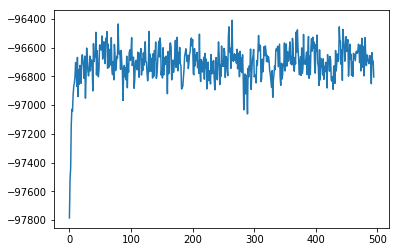

In [14]:
plt.plot(model.loglikelihoods_[5:])

In [19]:
#Generando algunos gráficos de los resultados
from matplotlib.pylab import hist, show

y=model.doc_topic_
#distribución de tópicos en todos los documentos
dist = sum(y)/len(noticias)
w=np.arange(0,true_k)
plt.bar(w,height=dist,alpha=0.5,tick_label=w)
show()

#distribución de tópicos en el documento 100
plt.bar(w,height=y[99],alpha=0.5,tick_label=w)
show()

#frecuencia de palabras por tópico
n_top_words=15
numo =np.arange(0,n_top_words)

for idx,topic in enumerate(model.topic_word_):
    d =[]
    s = []
    for i in topic.argsort()[:-n_top_words - 1:-1]:
        s.append(diccionario[i])
        d.append(topic[i])
    
    plt.barh(numo,width=d,alpha=0.5,tick_label=s)
    show()





AttributeError: 'KMeans' object has no attribute 'doc_topic_'

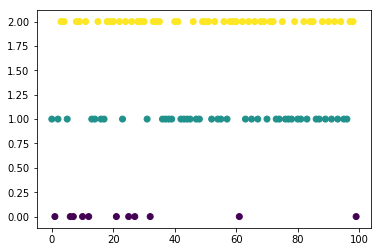

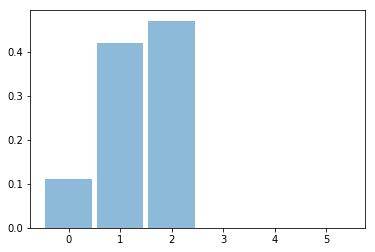

In [16]:
#calculando cluster en base al tópico mas frecuente
z=[]
for i in range(len(noticias)):
    z.append(np.argmax(y[i]))
plt.scatter(range(100),z,c=z)
show()

#distribución de cluster de acuerdo a la definición anterior
hist(z,bins=np.arange(-0.5,5.6,1),alpha=0.5,rwidth=0.9,density=True)
show()



<div style="border: 2px solid #1c75c8; background-color: #c5ddf6;">
<p>Pregunta Nº7: ¿Cómo se comparan estos resultados con los anteriores? ¿Qué puede decir de la convergencia de la estimación en este caso?
</p></div>